### Implementation of [Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf)

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import os
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os
import pickle
import random

import load_data
import models

Using TensorFlow backend.


In [2]:
print("notMNIST")
notMNIST_X_train, notMNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test = load_data.data_notMNIST()
print("MNIST")
MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test = load_data.data_MNIST()

notMNIST
20000 train samples
1000 valid samples
1000 test samples
MNIST
Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


In [3]:
def Ensembling_Data(M, MNIST_X_train, MNIST_Y_train):
#     M = 5
    sampled_indices = np.arange(0,MNIST_X_train.shape[0])
    random.shuffle(sampled_indices)

    cut = int(MNIST_X_train.shape[0]/M)
    index_sample_list = []
    for i in range(M):
        index_sample_list.append(sampled_indices[cut*i:cut*(i+1)])
        
    training_X_df = []; training_Y_df = []
    for index_range in index_sample_list:
        training_X_df.append(MNIST_X_train[[index_range]])
        training_Y_df.append(MNIST_Y_train[[index_range]])
        
    return training_X_df, training_Y_df

def NLL(pred_values, MNIST_Y_test, index_of_y):

    from keras import backend as K

    # generate NLL distribution
#     pred_hotcoded = np_utils.to_categorical(pred_values, 10)[index_of_y:index_of_y+1]

    # y_test = y_test.astype('float32') # necessary here, since y_pred comes in this type - check in your case with y_test.dtype and y_pred.dtype
    # y_test = K.constant(y_test)
    # y_pred = K.constant(y_pred)

#     y_pred = K.constant(pred_hotcoded)
    
    y_pred = K.constant(pred_values[index_of_y:index_of_y+1])

    g = K.categorical_crossentropy(target=MNIST_Y_test[index_of_y:index_of_y+1], output=y_pred)  # tensor
    ce = K.eval(g)  # 'ce' for cross-entropy
    ce.shape
    # (10000,) # i.e. one loss quantity per sample

    # sum up and divide with the no. of samples:
    log_loss = np.sum(ce)/ce.shape[0]
#     log_loss
    # 0.05165323486328125
    
    # https://stackoverflow.com/questions/52497625/how-to-calculate-negative-log-likelihoog-on-mnist-dataset
    return log_loss

def entropy_values(MNIST_Y_test, prediction):
    entropy_values=[]
    # Note: To obtain results faster, we use 200 samples for testing purposes
    for i in range(len(MNIST_Y_test[0:200])): # WARNING: Remove 100 limit, let whole dataframe!!!
        log_loss = NLL(prediction, MNIST_Y_test, i)
        entropy_values.append(log_loss)
#         print(i)
    #     print(log_loss)
    return entropy_values

# def entropy_values_faster(MNIST_Y_test, prediction):
# #     entropy_values=[]
# #     for i in range(len(MNIST_Y_test[0:])): # WARNING: Remove 100 limit, let whole dataframe!!!
# #         log_loss = NLL(prediction, MNIST_Y_test, i)
# #         entropy_values.append(log_loss)
#     entropy_values = [NLL(prediction, MNIST_Y_test, i) for i in range(len(MNIST_Y_test))]
#     #     print(log_loss)
#     return entropy_values



In [4]:
def ensembling_expt(M, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, model_function):
    
    training_X_df, training_Y_df = Ensembling_Data(M, MNIST_X_train, MNIST_Y_train)

    prediction_storage=[]
    acc_storage=[]
    for i in range(M):
        X_train = training_X_df[i]
        Y_train = training_Y_df[i]
#         model_function = models.MLP()
#         pred = models.MLP(X_train, Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test)
        pred, acc = model_function(X_train, Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test)
        prediction_storage.append(pred)
        acc_storage.append(acc)
#     print(prediction_storage[0])

    confi_list=[]
    for item in prediction_storage:
        tmplist=[]
        for array in item:
            confidence = max(array) # apparently this is defined as confidence by the paper??
            tmplist.append(confidence)
        confi_list.append(pd.Series(tmplist).mean())

    avg_predictions_from_ensemble=[]
    for j in range(len(prediction_storage[0])):
        tmpList=[]
        for i in range(M):
            tmpList.append(prediction_storage[i][j])
        pred_avg = np.average(tmpList, axis=0)
        avg_predictions_from_ensemble.append(pred_avg)
    acc_avg = np.average(acc_storage, axis=0)
    avg_predictions_from_ensemble2 = np.array([list(i) for i in avg_predictions_from_ensemble])
    entropy_val = entropy_values(MNIST_Y_test, avg_predictions_from_ensemble2)
    
    return entropy_val, acc_storage, confi_list

## Baseline (MC Dropout)

In [5]:
# M in MC dropout refers to number of MC dropout samples; since we're sampling different sets of indices, sort of sampling~

entropy_val_MLPmc_1, acc_MLPmc_1, confi_MLPmc_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MCDropout)
# entropy_val_MLPmc_5, acc_MLPmc_5, confi_MLPmc_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MCDropout)
# entropy_val_MLPmc_10, acc_MLPmc_10, confi_MLPmc_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MCDropout)

Nentropy_val_MLPmc_1, Nacc_MLPmc_1, Nconfi_MLPmc_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MCDropout)
# Nentropy_val_MLPmc_5, Nacc_MLPmc_5, Nconfi_MLPmc_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MCDropout)
# Nentropy_val_MLPmc_10, Nacc_MLPmc_10, Nconfi_MLPmc_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MCDropout)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


With Dropout & Batch Normalization


W0212 08:43:37.075741 139994954266368 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:158: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.

W0212 08:43:39.333325 139994954266368 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:171: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0212 08:43:39.338198 139994954266368 module_wrapper.py:139] From /home/root/adversarial/Gal/models.py:177: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0212 08:43:39.428727 139994954266368 deprecation.py:506] From /home/root/adversarial/Gal/models.py:192: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0212 08:43:39.543873 139994954266368 module_wrapper.py:139] From /home

Epoch:0 | Train loss: 46.47 | Train acc: 0.922 | Test acc:0.923
Epoch:1 | Train loss: 34.87 | Train acc: 0.949 | Test acc:0.944
Epoch:2 | Train loss: 26.31 | Train acc: 0.961 | Test acc:0.954
Epoch:3 | Train loss: 19.93 | Train acc: 0.971 | Test acc:0.960
Epoch:4 | Train loss: 15.15 | Train acc: 0.975 | Test acc:0.961
Epoch:5 | Train loss: 11.58 | Train acc: 0.980 | Test acc:0.965
Epoch:6 | Train loss: 8.91 | Train acc: 0.982 | Test acc:0.966
Epoch:7 | Train loss: 6.92 | Train acc: 0.985 | Test acc:0.969
Epoch:8 | Train loss: 5.45 | Train acc: 0.987 | Test acc:0.968
Epoch:9 | Train loss: 4.36 | Train acc: 0.988 | Test acc:0.970
Epoch:10 | Train loss: 3.57 | Train acc: 0.990 | Test acc:0.970
Epoch:11 | Train loss: 2.99 | Train acc: 0.990 | Test acc:0.971
Epoch:12 | Train loss: 2.57 | Train acc: 0.990 | Test acc:0.972
Epoch:13 | Train loss: 2.26 | Train acc: 0.991 | Test acc:0.972
With Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 45.47 | Train acc: 0.926 | Test acc:0.926
Epoch:1 | Train loss: 33.97 | Train acc: 0.955 | Test acc:0.950
Epoch:2 | Train loss: 25.56 | Train acc: 0.966 | Test acc:0.956
Epoch:3 | Train loss: 19.34 | Train acc: 0.973 | Test acc:0.962
Epoch:4 | Train loss: 14.71 | Train acc: 0.977 | Test acc:0.965
Epoch:5 | Train loss: 11.25 | Train acc: 0.982 | Test acc:0.969
Epoch:6 | Train loss: 8.67 | Train acc: 0.983 | Test acc:0.968
Epoch:7 | Train loss: 6.75 | Train acc: 0.986 | Test acc:0.968
Epoch:8 | Train loss: 5.31 | Train acc: 0.988 | Test acc:0.971
Epoch:9 | Train loss: 4.25 | Train acc: 0.989 | Test acc:0.972
Epoch:10 | Train loss: 3.46 | Train acc: 0.990 | Test acc:0.971
Epoch:11 | Train loss: 2.88 | Train acc: 0.991 | Test acc:0.975
Epoch:12 | Train loss: 2.46 | Train acc: 0.992 | Test acc:0.975
Epoch:13 | Train loss: 2.16 | Train acc: 0.992 | Test acc:0.973


W0212 08:44:39.157028 139994954266368 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0212 08:44:39.163150 139994954266368 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0212 08:44:39.164153 139994954266368 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0212 08:44:39.165262 139994954266368 module_wrapper.py:139] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

/usr/local/lib/python3.5/dist-packages/ipykern

With Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 50.46 | Train acc: 0.929 | Test acc:0.114
Epoch:1 | Train loss: 38.23 | Train acc: 0.954 | Test acc:0.103
Epoch:2 | Train loss: 29.09 | Train acc: 0.966 | Test acc:0.109
Epoch:3 | Train loss: 22.20 | Train acc: 0.974 | Test acc:0.099
Epoch:4 | Train loss: 16.98 | Train acc: 0.978 | Test acc:0.118
Epoch:5 | Train loss: 13.04 | Train acc: 0.983 | Test acc:0.106
Epoch:6 | Train loss: 10.05 | Train acc: 0.985 | Test acc:0.100
Epoch:7 | Train loss: 7.79 | Train acc: 0.986 | Test acc:0.104
Epoch:8 | Train loss: 6.09 | Train acc: 0.988 | Test acc:0.111
Epoch:9 | Train loss: 4.81 | Train acc: 0.989 | Test acc:0.111
Epoch:10 | Train loss: 3.87 | Train acc: 0.990 | Test acc:0.104
Epoch:11 | Train loss: 3.17 | Train acc: 0.991 | Test acc:0.091
Epoch:12 | Train loss: 2.65 | Train acc: 0.992 | Test acc:0.098
Epoch:13 | Train loss: 2.28 | Train acc: 0.991 | Test acc:0.096
With Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 45.23 | Train acc: 0.928 | Test acc:0.117
Epoch:1 | Train loss: 33.87 | Train acc: 0.952 | Test acc:0.107
Epoch:2 | Train loss: 25.55 | Train acc: 0.964 | Test acc:0.113
Epoch:3 | Train loss: 19.40 | Train acc: 0.971 | Test acc:0.124
Epoch:4 | Train loss: 14.83 | Train acc: 0.975 | Test acc:0.128
Epoch:5 | Train loss: 11.41 | Train acc: 0.980 | Test acc:0.104
Epoch:6 | Train loss: 8.86 | Train acc: 0.981 | Test acc:0.125
Epoch:7 | Train loss: 6.95 | Train acc: 0.985 | Test acc:0.113
Epoch:8 | Train loss: 5.53 | Train acc: 0.987 | Test acc:0.101
Epoch:9 | Train loss: 4.47 | Train acc: 0.989 | Test acc:0.110
Epoch:10 | Train loss: 3.68 | Train acc: 0.989 | Test acc:0.110
Epoch:11 | Train loss: 3.09 | Train acc: 0.990 | Test acc:0.101
Epoch:12 | Train loss: 2.66 | Train acc: 0.991 | Test acc:0.102
Epoch:13 | Train loss: 2.33 | Train acc: 0.992 | Test acc:0.117


## Ensembling MLP & variants

### MNIST plots

In [6]:
entropy_val_MLP_1, acc_MLP_1, confi_MLP_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP)
# entropy_val_MLP_5, acc_MLP_5, confi_MLP_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP)
# entropy_val_MLP_10, acc_MLP_10, confi_MLP_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout, Vanilla MLP
Epoch:0 | Train loss: 38.61 | Train acc: 0.913 | Test acc:0.912
Epoch:1 | Train loss: 28.27 | Train acc: 0.940 | Test acc:0.933
Epoch:2 | Train loss: 20.85 | Train acc: 0.955 | Test acc:0.947
Epoch:3 | Train loss: 15.46 | Train acc: 0.964 | Test acc:0.953
Epoch:4 | Train loss: 11.55 | Train acc: 0.967 | Test acc:0.955
Epoch:5 | Train loss: 8.68 | Train acc: 0.977 | Test acc:0.962
Epoch:6 | Train loss: 6.60 | Train acc: 0.980 | Test acc:0.964
Epoch:7 | Train loss: 5.09 | Train acc: 0.985 | Test acc:0.966
Epoch:8 | Train loss: 3.99 | Train acc: 0.984 | Test acc:0.966
Epoch:9 | Train loss: 3.21 | Train acc: 0.987 | Test acc:0.968
Epoch:10 | Train loss: 2.65 | Train acc: 0.988 | Test acc:0.968
Epoch:11 | Train loss: 2.26 | Train acc: 0.991 | Test acc:0.969
Epoch:12 | Train loss: 1.99 | Train acc: 0.990 | Test acc:0.967
Epoch:13 | Train loss: 1.81 | Train acc: 0.988 | Test acc:0.962
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 44.58 | Train acc: 0.917 | Test acc:0.916
Epoch:1 | Train loss: 33.17 | Train acc: 0.942 | Test acc:0.937
Epoch:2 | Train loss: 24.83 | Train acc: 0.955 | Test acc:0.945
Epoch:3 | Train loss: 18.68 | Train acc: 0.964 | Test acc:0.953
Epoch:4 | Train loss: 14.14 | Train acc: 0.964 | Test acc:0.950
Epoch:5 | Train loss: 10.76 | Train acc: 0.976 | Test acc:0.961
Epoch:6 | Train loss: 8.26 | Train acc: 0.978 | Test acc:0.961
Epoch:7 | Train loss: 6.41 | Train acc: 0.983 | Test acc:0.965
Epoch:8 | Train loss: 5.04 | Train acc: 0.985 | Test acc:0.967
Epoch:9 | Train loss: 4.03 | Train acc: 0.986 | Test acc:0.967
Epoch:10 | Train loss: 3.29 | Train acc: 0.987 | Test acc:0.970
Epoch:11 | Train loss: 2.76 | Train acc: 0.984 | Test acc:0.967
Epoch:12 | Train loss: 2.37 | Train acc: 0.987 | Test acc:0.966
Epoch:13 | Train loss: 2.09 | Train acc: 0.989 | Test acc:0.968


In [7]:
entropy_val_MLPr_1, acc_MLPr_1, confi_MLPr_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_randomperturbation)
# entropy_val_MLPr_5, acc_MLPr_5, confi_MLPr_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_randomperturbation)
# entropy_val_MLPr_10, acc_MLPr_10, confi_MLPr_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_randomperturbation)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:656: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((30000, 784), (30000, 10))
Epoch:0 | Train loss: 46.67 | Train acc: 0.832 | Test acc:0.833
Epoch:1 | Train loss: 33.20 | Train acc: 0.871 | Test acc:0.864
Epoch:2 | Train loss: 23.77 | Train acc: 0.767 | Test acc:0.750
Epoch:3 | Train loss: 17.00 | Train acc: 0.948 | Test acc:0.936
Epoch:4 | Train loss: 12.30 | Train acc: 0.937 | Test acc:0.927
Epoch:5 | Train loss: 8.95 | Train acc: 0.961 | Test acc:0.950
Epoch:6 | Train loss: 6.60 | Train acc: 0.969 | Test acc:0.954
Epoch:7 | Train loss: 4.95 | Train acc: 0.977 | Test acc:0.959
Epoch:8 | Train loss: 3.83 | Train acc: 0.960 | Test acc:0.946
Epoch:9 | Train loss: 3.04 | Train acc: 0.972 | Test acc:0.951
Epoch:10 | Train loss: 2.49 | Train acc: 0.985 | Test acc:0.965
Epoch:11 | Train loss: 2.14 | Train acc: 0.975 | Test acc:0.953
Epoch:12 | Train loss: 1.90 | Train acc: 0.987 | Test acc:0.966
Epoch:13 | Train loss: 1.74 | Train acc: 0.983 | Test acc:0.962
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:656: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((30000, 784), (30000, 10))
Epoch:0 | Train loss: 42.13 | Train acc: 0.784 | Test acc:0.789
Epoch:1 | Train loss: 29.63 | Train acc: 0.826 | Test acc:0.824
Epoch:2 | Train loss: 21.00 | Train acc: 0.943 | Test acc:0.938
Epoch:3 | Train loss: 15.11 | Train acc: 0.870 | Test acc:0.862
Epoch:4 | Train loss: 10.89 | Train acc: 0.958 | Test acc:0.944
Epoch:5 | Train loss: 7.98 | Train acc: 0.968 | Test acc:0.952
Epoch:6 | Train loss: 5.94 | Train acc: 0.972 | Test acc:0.957
Epoch:7 | Train loss: 4.52 | Train acc: 0.975 | Test acc:0.959
Epoch:8 | Train loss: 3.61 | Train acc: 0.874 | Test acc:0.862
Epoch:9 | Train loss: 2.85 | Train acc: 0.965 | Test acc:0.949
Epoch:10 | Train loss: 2.38 | Train acc: 0.973 | Test acc:0.953
Epoch:11 | Train loss: 2.10 | Train acc: 0.916 | Test acc:0.905
Epoch:12 | Train loss: 1.84 | Train acc: 0.983 | Test acc:0.964
Epoch:13 | Train loss: 1.69 | Train acc: 0.989 | Test acc:0.968


In [8]:
entropy_val_MLPat_1, acc_MLPat_1, confi_MLPat_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_adversarialtraining)
# entropy_val_MLPat_5, acc_MLPat_5, confi_MLPat_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_adversarialtraining)
# entropy_val_MLPat_10, acc_MLPat_10, confi_MLPat_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, MNIST_X_val, MNIST_Y_val, MNIST_X_test, MNIST_Y_test, models.MLP_adversarialtraining)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 56.64 | Train acc: 0.963 | Test acc:0.957
Epoch:1 | Train loss: 43.27 | Train acc: 0.980 | Test acc:0.964
Epoch:2 | Train loss: 33.18 | Train acc: 0.988 | Test acc:0.970
Epoch:3 | Train loss: 25.52 | Train acc: 0.992 | Test acc:0.970
Epoch:4 | Train loss: 19.67 | Train acc: 0.994 | Test acc:0.976
Epoch:5 | Train loss: 15.21 | Train acc: 0.995 | Test acc:0.971
Epoch:6 | Train loss: 11.81 | Train acc: 0.996 | Test acc:0.974
Epoch:7 | Train loss: 9.22 | Train acc: 0.996 | Test acc:0.974
Epoch:8 | Train loss: 7.27 | Train acc: 0.997 | Test acc:0.975
Epoch:9 | Train loss: 5.80 | Train acc: 0.997 | Test acc:0.974
Epoch:10 | Train loss: 4.69 | Train acc: 0.997 | Test acc:0.974
Epoch:11 | Train loss: 3.86 | Train acc: 0.997 | Test acc:0.975
Epoch:12 | Train loss: 3.24 | Train acc: 0.997 | Test acc:0.975
Epoch:13 | Train loss: 2.78 | Train acc: 0.998 | Test acc:0.977
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:421: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:422: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 42.07 | Train acc: 0.822 | Test acc:0.956
Epoch:1 | Train loss: 29.52 | Train acc: 0.835 | Test acc:0.965
Epoch:2 | Train loss: 20.84 | Train acc: 0.841 | Test acc:0.971
Epoch:3 | Train loss: 14.78 | Train acc: 0.844 | Test acc:0.973
Epoch:4 | Train loss: 10.55 | Train acc: 0.843 | Test acc:0.974
Epoch:5 | Train loss: 7.61 | Train acc: 0.846 | Test acc:0.974
Epoch:6 | Train loss: 5.58 | Train acc: 0.846 | Test acc:0.973
Epoch:7 | Train loss: 4.19 | Train acc: 0.846 | Test acc:0.975
Epoch:8 | Train loss: 3.25 | Train acc: 0.848 | Test acc:0.975
Epoch:9 | Train loss: 2.62 | Train acc: 0.848 | Test acc:0.977
Epoch:10 | Train loss: 2.21 | Train acc: 0.847 | Test acc:0.974
Epoch:11 | Train loss: 1.93 | Train acc: 0.848 | Test acc:0.976
Epoch:12 | Train loss: 1.76 | Train acc: 0.847 | Test acc:0.975
Epoch:13 | Train loss: 1.64 | Train acc: 0.848 | Test acc:0.977
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 41.45 | Train acc: 0.965 | Test acc:0.956
Epoch:1 | Train loss: 30.55 | Train acc: 0.982 | Test acc:0.965
Epoch:2 | Train loss: 22.65 | Train acc: 0.987 | Test acc:0.967
Epoch:3 | Train loss: 16.88 | Train acc: 0.993 | Test acc:0.972
Epoch:4 | Train loss: 12.64 | Train acc: 0.993 | Test acc:0.971
Epoch:5 | Train loss: 9.54 | Train acc: 0.995 | Test acc:0.974
Epoch:6 | Train loss: 7.27 | Train acc: 0.996 | Test acc:0.973
Epoch:7 | Train loss: 5.61 | Train acc: 0.997 | Test acc:0.974
Epoch:8 | Train loss: 4.41 | Train acc: 0.997 | Test acc:0.974
Epoch:9 | Train loss: 3.54 | Train acc: 0.998 | Test acc:0.972
Epoch:10 | Train loss: 2.92 | Train acc: 0.998 | Test acc:0.973
Epoch:11 | Train loss: 2.48 | Train acc: 0.998 | Test acc:0.975
Epoch:12 | Train loss: 2.16 | Train acc: 0.998 | Test acc:0.976
Epoch:13 | Train loss: 1.94 | Train acc: 0.998 | Test acc:0.974
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:421: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:422: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 41.59 | Train acc: 0.825 | Test acc:0.958
Epoch:1 | Train loss: 29.30 | Train acc: 0.836 | Test acc:0.967
Epoch:2 | Train loss: 20.82 | Train acc: 0.841 | Test acc:0.970
Epoch:3 | Train loss: 14.91 | Train acc: 0.845 | Test acc:0.971
Epoch:4 | Train loss: 10.76 | Train acc: 0.845 | Test acc:0.971
Epoch:5 | Train loss: 7.84 | Train acc: 0.847 | Test acc:0.973
Epoch:6 | Train loss: 5.80 | Train acc: 0.847 | Test acc:0.975
Epoch:7 | Train loss: 4.38 | Train acc: 0.846 | Test acc:0.972
Epoch:8 | Train loss: 3.41 | Train acc: 0.846 | Test acc:0.974
Epoch:9 | Train loss: 2.74 | Train acc: 0.846 | Test acc:0.975
Epoch:10 | Train loss: 2.28 | Train acc: 0.848 | Test acc:0.974
Epoch:11 | Train loss: 1.98 | Train acc: 0.848 | Test acc:0.973
Epoch:12 | Train loss: 1.79 | Train acc: 0.847 | Test acc:0.973
Epoch:13 | Train loss: 1.66 | Train acc: 0.848 | Test acc:0.974


### notMNIST plots

In [9]:
Nentropy_val_MLP_1, Nacc_MLP_1, Nconfi_MLP_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP)
# Nentropy_val_MLP_5, Nacc_MLP_5, Nconfi_MLP_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP)
# Nentropy_val_MLP_10, Nacc_MLP_10, Nconfi_MLP_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout, Vanilla MLP
Epoch:0 | Train loss: 44.27 | Train acc: 0.915 | Test acc:0.078
Epoch:1 | Train loss: 32.93 | Train acc: 0.942 | Test acc:0.069
Epoch:2 | Train loss: 24.62 | Train acc: 0.952 | Test acc:0.055
Epoch:3 | Train loss: 18.47 | Train acc: 0.965 | Test acc:0.057
Epoch:4 | Train loss: 13.93 | Train acc: 0.968 | Test acc:0.040
Epoch:5 | Train loss: 10.57 | Train acc: 0.974 | Test acc:0.044
Epoch:6 | Train loss: 8.08 | Train acc: 0.980 | Test acc:0.045
Epoch:7 | Train loss: 6.24 | Train acc: 0.977 | Test acc:0.044
Epoch:8 | Train loss: 4.88 | Train acc: 0.987 | Test acc:0.044
Epoch:9 | Train loss: 3.89 | Train acc: 0.984 | Test acc:0.045
Epoch:10 | Train loss: 3.17 | Train acc: 0.988 | Test acc:0.062
Epoch:11 | Train loss: 2.65 | Train acc: 0.988 | Test acc:0.060
Epoch:12 | Train loss: 2.27 | Train acc: 0.990 | Test acc:0.062
Epoch:13 | Train loss: 2.01 | Train acc: 0.992 | Test acc:0.062
Without Dropout, Vanilla MLP


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 48.86 | Train acc: 0.914 | Test acc:0.048
Epoch:1 | Train loss: 37.04 | Train acc: 0.939 | Test acc:0.071
Epoch:2 | Train loss: 28.23 | Train acc: 0.955 | Test acc:0.065
Epoch:3 | Train loss: 21.60 | Train acc: 0.964 | Test acc:0.067
Epoch:4 | Train loss: 16.59 | Train acc: 0.968 | Test acc:0.086
Epoch:5 | Train loss: 12.80 | Train acc: 0.976 | Test acc:0.091
Epoch:6 | Train loss: 9.93 | Train acc: 0.977 | Test acc:0.087
Epoch:7 | Train loss: 7.75 | Train acc: 0.983 | Test acc:0.098
Epoch:8 | Train loss: 6.11 | Train acc: 0.982 | Test acc:0.072
Epoch:9 | Train loss: 4.88 | Train acc: 0.987 | Test acc:0.068
Epoch:10 | Train loss: 3.95 | Train acc: 0.988 | Test acc:0.071
Epoch:11 | Train loss: 3.25 | Train acc: 0.989 | Test acc:0.082
Epoch:12 | Train loss: 2.74 | Train acc: 0.991 | Test acc:0.110
Epoch:13 | Train loss: 2.36 | Train acc: 0.992 | Test acc:0.105


In [10]:
Nentropy_val_MLPr_1, Nacc_MLPr_1, Nconfi_MLPr_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_randomperturbation)
# Nentropy_val_MLPr_5, Nacc_MLPr_5, Nconfi_MLPr_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_randomperturbation)
# Nentropy_val_MLPr_10, Nacc_MLPr_10, Nconfi_MLPr_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_randomperturbation)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:656: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((30000, 784), (30000, 10))
Epoch:0 | Train loss: 38.02 | Train acc: 0.802 | Test acc:0.064
Epoch:1 | Train loss: 26.20 | Train acc: 0.887 | Test acc:0.055
Epoch:2 | Train loss: 18.29 | Train acc: 0.897 | Test acc:0.067
Epoch:3 | Train loss: 12.88 | Train acc: 0.932 | Test acc:0.056
Epoch:4 | Train loss: 9.17 | Train acc: 0.968 | Test acc:0.083
Epoch:5 | Train loss: 6.65 | Train acc: 0.971 | Test acc:0.067
Epoch:6 | Train loss: 4.94 | Train acc: 0.939 | Test acc:0.080
Epoch:7 | Train loss: 3.75 | Train acc: 0.972 | Test acc:0.077
Epoch:8 | Train loss: 2.96 | Train acc: 0.967 | Test acc:0.076
Epoch:9 | Train loss: 2.44 | Train acc: 0.963 | Test acc:0.090
Epoch:10 | Train loss: 2.07 | Train acc: 0.985 | Test acc:0.078
Epoch:11 | Train loss: 1.86 | Train acc: 0.964 | Test acc:0.075
Epoch:12 | Train loss: 1.70 | Train acc: 0.985 | Test acc:0.063
Epoch:13 | Train loss: 1.64 | Train acc: 0.926 | Test acc:0.051
Without Dropout, MLP with random perturbations


/home/root/adversarial/Gal/models.py:656: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:657: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

New training set shape (X,Y):  ((30000, 784), (30000, 10))
Epoch:0 | Train loss: 37.95 | Train acc: 0.840 | Test acc:0.048
Epoch:1 | Train loss: 26.32 | Train acc: 0.902 | Test acc:0.073
Epoch:2 | Train loss: 18.44 | Train acc: 0.913 | Test acc:0.087
Epoch:3 | Train loss: 13.13 | Train acc: 0.835 | Test acc:0.096
Epoch:4 | Train loss: 9.35 | Train acc: 0.956 | Test acc:0.074
Epoch:5 | Train loss: 6.82 | Train acc: 0.969 | Test acc:0.090
Epoch:6 | Train loss: 5.11 | Train acc: 0.948 | Test acc:0.079
Epoch:7 | Train loss: 3.91 | Train acc: 0.976 | Test acc:0.077
Epoch:8 | Train loss: 3.11 | Train acc: 0.949 | Test acc:0.067
Epoch:9 | Train loss: 2.55 | Train acc: 0.974 | Test acc:0.096
Epoch:10 | Train loss: 2.16 | Train acc: 0.989 | Test acc:0.078
Epoch:11 | Train loss: 1.92 | Train acc: 0.980 | Test acc:0.089
Epoch:12 | Train loss: 1.75 | Train acc: 0.976 | Test acc:0.093
Epoch:13 | Train loss: 1.64 | Train acc: 0.979 | Test acc:0.082


In [11]:
Nentropy_val_MLPat_1, Nacc_MLPat_1, Nconfi_MLPat_1 = ensembling_expt(2, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_adversarialtraining)
# Nentropy_val_MLPat_5, Nacc_MLPat_5, Nconfi_MLPat_5 = ensembling_expt(5, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_adversarialtraining)
# Nentropy_val_MLPat_10, Nacc_MLPat_10, Nconfi_MLPat_10 = ensembling_expt(10, MNIST_X_train, MNIST_Y_train, notMNIST_X_val, notMNIST_Y_val, notMNIST_X_test, notMNIST_Y_test, models.MLP_adversarialtraining)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnin

Without Dropout & Batch Normalization
Epoch:0 | Train loss: 47.91 | Train acc: 0.964 | Test acc:0.104
Epoch:1 | Train loss: 36.30 | Train acc: 0.981 | Test acc:0.100
Epoch:2 | Train loss: 27.71 | Train acc: 0.988 | Test acc:0.117
Epoch:3 | Train loss: 21.26 | Train acc: 0.993 | Test acc:0.122
Epoch:4 | Train loss: 16.40 | Train acc: 0.993 | Test acc:0.113
Epoch:5 | Train loss: 12.71 | Train acc: 0.996 | Test acc:0.114
Epoch:6 | Train loss: 9.92 | Train acc: 0.997 | Test acc:0.106
Epoch:7 | Train loss: 7.79 | Train acc: 0.997 | Test acc:0.104
Epoch:8 | Train loss: 6.18 | Train acc: 0.997 | Test acc:0.109
Epoch:9 | Train loss: 4.96 | Train acc: 0.998 | Test acc:0.118
Epoch:10 | Train loss: 4.04 | Train acc: 0.998 | Test acc:0.117
Epoch:11 | Train loss: 3.35 | Train acc: 0.998 | Test acc:0.121
Epoch:12 | Train loss: 2.83 | Train acc: 0.998 | Test acc:0.111
Epoch:13 | Train loss: 2.45 | Train acc: 0.998 | Test acc:0.106
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:421: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:422: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 37.64 | Train acc: 0.825 | Test acc:0.120
Epoch:1 | Train loss: 26.34 | Train acc: 0.836 | Test acc:0.106
Epoch:2 | Train loss: 18.63 | Train acc: 0.841 | Test acc:0.114
Epoch:3 | Train loss: 13.29 | Train acc: 0.844 | Test acc:0.086
Epoch:4 | Train loss: 9.58 | Train acc: 0.845 | Test acc:0.069
Epoch:5 | Train loss: 6.99 | Train acc: 0.846 | Test acc:0.091
Epoch:6 | Train loss: 5.20 | Train acc: 0.847 | Test acc:0.075
Epoch:7 | Train loss: 3.97 | Train acc: 0.847 | Test acc:0.103
Epoch:8 | Train loss: 3.13 | Train acc: 0.847 | Test acc:0.080
Epoch:9 | Train loss: 2.56 | Train acc: 0.849 | Test acc:0.088
Epoch:10 | Train loss: 2.18 | Train acc: 0.848 | Test acc:0.083
Epoch:11 | Train loss: 1.93 | Train acc: 0.846 | Test acc:0.096
Epoch:12 | Train loss: 1.76 | Train acc: 0.849 | Test acc:0.116
Epoch:13 | Train loss: 1.66 | Train acc: 0.848 | Test acc:0.102
Without Dropout & Batch Normalization


/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch:0 | Train loss: 46.35 | Train acc: 0.966 | Test acc:0.133
Epoch:1 | Train loss: 34.60 | Train acc: 0.982 | Test acc:0.104
Epoch:2 | Train loss: 25.95 | Train acc: 0.988 | Test acc:0.107
Epoch:3 | Train loss: 19.51 | Train acc: 0.992 | Test acc:0.108
Epoch:4 | Train loss: 14.71 | Train acc: 0.992 | Test acc:0.114
Epoch:5 | Train loss: 11.13 | Train acc: 0.995 | Test acc:0.101
Epoch:6 | Train loss: 8.47 | Train acc: 0.997 | Test acc:0.101
Epoch:7 | Train loss: 6.50 | Train acc: 0.996 | Test acc:0.089
Epoch:8 | Train loss: 5.06 | Train acc: 0.995 | Test acc:0.090
Epoch:9 | Train loss: 4.00 | Train acc: 0.997 | Test acc:0.081
Epoch:10 | Train loss: 3.23 | Train acc: 0.998 | Test acc:0.094
Epoch:11 | Train loss: 2.68 | Train acc: 0.996 | Test acc:0.104
Epoch:12 | Train loss: 2.29 | Train acc: 0.997 | Test acc:0.096
Epoch:13 | Train loss: 2.02 | Train acc: 0.998 | Test acc:0.097
Without Dropout & Batch Normalization & Adversarial Training


/home/root/adversarial/Gal/models.py:421: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_X_train = X_train[[ind]] # X_train[[start_index,end_index]] ; this would let us take specific indices, so we can randomize the order, ensure each iteration is taking precisely unique samples
/home/root/adversarial/Gal/models.py:422: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sample_Y_train = Y_train[[ind]]
/usr/local/lib/python3.5/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already activ

Epoch:0 | Train loss: 41.23 | Train acc: 0.823 | Test acc:0.099
Epoch:1 | Train loss: 28.83 | Train acc: 0.837 | Test acc:0.098
Epoch:2 | Train loss: 20.30 | Train acc: 0.841 | Test acc:0.092
Epoch:3 | Train loss: 14.38 | Train acc: 0.845 | Test acc:0.092
Epoch:4 | Train loss: 10.26 | Train acc: 0.845 | Test acc:0.102
Epoch:5 | Train loss: 7.39 | Train acc: 0.846 | Test acc:0.087
Epoch:6 | Train loss: 5.40 | Train acc: 0.846 | Test acc:0.093
Epoch:7 | Train loss: 4.03 | Train acc: 0.848 | Test acc:0.077
Epoch:8 | Train loss: 3.11 | Train acc: 0.847 | Test acc:0.076
Epoch:9 | Train loss: 2.49 | Train acc: 0.848 | Test acc:0.094
Epoch:10 | Train loss: 2.08 | Train acc: 0.849 | Test acc:0.099
Epoch:11 | Train loss: 1.83 | Train acc: 0.847 | Test acc:0.088
Epoch:12 | Train loss: 1.67 | Train acc: 0.848 | Test acc:0.074
Epoch:13 | Train loss: 1.57 | Train acc: 0.849 | Test acc:0.070


## Figure 3(a) plots

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


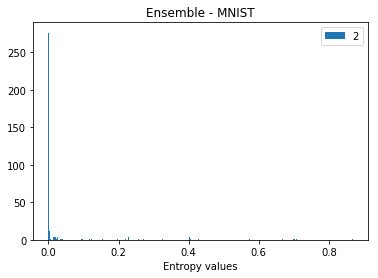

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLP_1, normed=True, bins=300, label = '2')
# plt.hist(entropy_val_MLP_5, normed=True, bins=300, label = '5')
# plt.hist(entropy_val_MLP_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble - MNIST")
plt.legend()
plt.show()

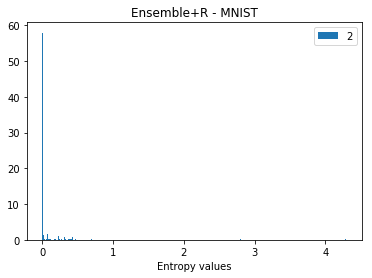

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLPr_1, normed=True, bins=300, label = '2')
# plt.hist(entropy_val_MLPr_5, normed=True, bins=300, label = '5')
# plt.hist(entropy_val_MLPr_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+R - MNIST")
plt.legend()
plt.show()

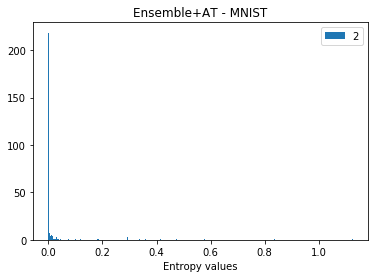

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLPat_1, normed=True, bins=300, label = '2')
# plt.hist(entropy_val_MLPat_5, normed=True, bins=300, label = '5')
# plt.hist(entropy_val_MLPat_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+AT - MNIST")
plt.legend()
plt.show()

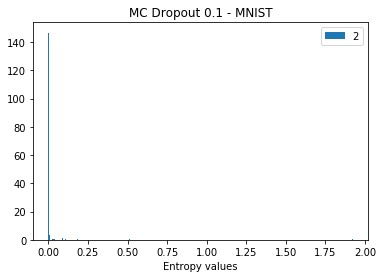

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(entropy_val_MLPmc_1, normed=True, bins=300, label = '2')
# plt.hist(entropy_val_MLPmc_5, normed=True, bins=300, label = '5')
# plt.hist(entropy_val_MLPmc_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("MC Dropout 0.1 - MNIST")
plt.legend()
plt.show()

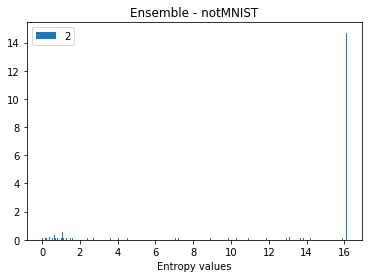

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLP_1, normed=True, bins=300, label = '2')
# plt.hist(Nentropy_val_MLP_5, normed=True, bins=300, label = '5')
# plt.hist(Nentropy_val_MLP_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble - notMNIST")
plt.legend()
plt.show()

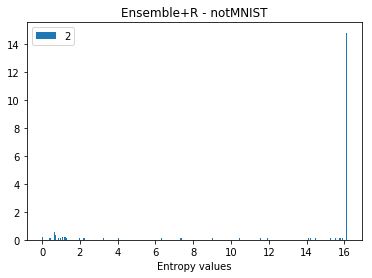

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLPr_1, normed=True, bins=300, label = '2')
# plt.hist(Nentropy_val_MLPr_5, normed=True, bins=300, label = '5')
# plt.hist(Nentropy_val_MLPr_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+R - notMNIST")
plt.legend()
plt.show()

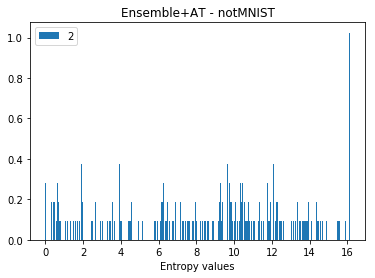

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLPat_1, normed=True, bins=300, label = '2')
# plt.hist(Nentropy_val_MLPat_5, normed=True, bins=300, label = '5')
# plt.hist(Nentropy_val_MLPat_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("Ensemble+AT - notMNIST")
plt.legend()
plt.show()

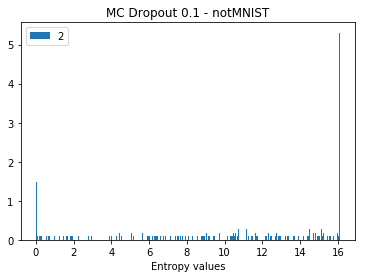

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Nentropy_val_MLPmc_1, normed=True, bins=300, label = '2')
# plt.hist(Nentropy_val_MLPmc_5, normed=True, bins=300, label = '5')
# plt.hist(Nentropy_val_MLPmc_10, normed=True, bins=300, label = '10')
plt.xlabel('Entropy values')
plt.title("MC Dropout 0.1 - notMNIST")
plt.legend()
plt.show()

## Figure 6 plots

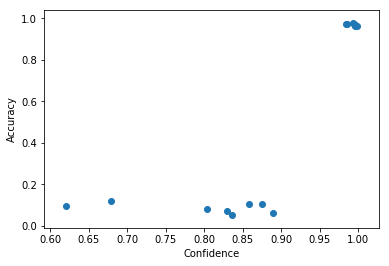

In [20]:
# Fig 6 test

import matplotlib.pyplot as plt
%matplotlib inline

confi_complete_list = [confi_MLP_1, confi_MLPr_1, confi_MLPat_1, confi_MLPmc_1, Nconfi_MLP_1, Nconfi_MLPr_1, Nconfi_MLPat_1, Nconfi_MLPmc_1]
acc_complete_list = [acc_MLP_1, acc_MLPr_1, acc_MLPat_1, acc_MLPmc_1, Nacc_MLP_1, Nacc_MLPr_1, Nacc_MLPat_1, Nacc_MLPmc_1]

plt.scatter(confi_complete_list, acc_complete_list)
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
# plt.legend()
plt.show()